<font color='Green' size='8' style='line-height: 1.01;'><b>Starbucks Coding Challenge</b></font>

<font color='Green' size='5' style='line-height: 1.01;'><b>Data Analyst, Pricing and Applied Economics</b></font>

# Q1
## High-level Idea
The procedure begins by merging two tables in `MergedTables` to ensure `ProductDescription` is accessible. The focus then shifts to identifying transactions that exclusively involve `WaterCup` without including any other items.

In [1]:
import sqlite3  # Database library
import pandas as pd  # Data manipulation library

# Connect to the database file
conn = sqlite3.connect("/Users/dadmehr/Codes/Python/Starbucks Data Analyst Code Challenge/Data.sqlite3")

description_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
)

SELECT ProductDescription, COUNT(*) AS Count
FROM MergedTables
GROUP BY ProductDescription;
"""

# MergedTables: This combines LineItemSales with ProductIds by matching on ItemId.
# The query counts occurrences of each ProductDescription.

pd.read_sql_query(description_query, conn)

,ProductDescription,Count
0,None,25262
1,OtherProduct,329123
2,Syrup,27385
3,WaterCup,4962


- **NOTE:** I assumed WaterCup is the "water" question referring to.

In [2]:
water_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
),

OnlyWater AS (
    SELECT *
    FROM MergedTables
    WHERE ProductDescription = 'WaterCup'
    AND POSTransactionId NOT IN (
        SELECT POSTransactionId
        FROM MergedTables
        WHERE ProductDescription != 'WaterCup'
    )
)

SELECT * 
FROM OnlyWater;
"""
# MergedTables: Joins LineItemSales with ProductIds on ItemId.
# OnlyWater: Includes transactions exclusively involving 'WaterCup', excluding any others.

# Data inspection
pd.read_sql_query(water_query, conn)

,FiscalWeekBeginDate,POSTransactionId,ParentItemId,ItemId,ItemQuantity,NetSales,ProductDescription
0,2023-06-05,20230606010379011988,11134422,11134422,1.0,0.0,WaterCup
1,2023-06-12,20230612010379016133,11134422,11134422,1.0,0.0,WaterCup
2,2023-06-12,20230618010379012613,11134422,11134422,1.0,0.0,WaterCup
3,2023-06-19,20230624010379036514,11134422,11134422,1.0,0.0,WaterCup
4,2023-07-24,20230728010379036136,11134422,11134422,1.0,0.0,WaterCup
...,...,...,...,...,...,...,...
564,2023-09-18,20230922010379031956,11015038,11015038,1.0,0.0,WaterCup
565,2023-09-18,20230922010379031956,11015038,11015038,1.0,0.0,WaterCup
566,2023-09-25,20230925010379034138,11015038,11015038,1.0,0.0,WaterCup
567,2023-09-25,20230928010379036423,11015038,11015038,1.0,0.0,WaterCup


In [3]:
only_water = pd.read_sql_query(water_query, conn)

total_transactions = len(only_water["ItemQuantity"])
total_water_units = sum(only_water["ItemQuantity"])
total_revenue = sum(only_water["NetSales"])

print(f"Number of water units is {total_water_units}.")
print(f"Number of transactions with only water(s) is {total_transactions}.")
print(f"Revenue generated is {total_revenue}")

Number of water units is 578.0.
Number of transactions with only water(s) is 569.
Revenue generated is 0.0


**NOTE:**  Note: Revenue generated is 0; yet considered 'purchased'.

# Q2
## High-level Idea
The process starts by identifying `Syrup` transactions in `ProductDescription`. Next, it focuses on the `ParentItemId` and all associated items, summing the `NetSales` of these items and dividing by the `ItemQuantity` of the parent (which can sometimes be more than one). The final step is to calculate the weekly average price for drinks containing syrup. A key aspect is accurately identifying all items linked to a `Syrup` parent item and carrying the parent quantity.

In [4]:
syrup_query = """
WITH MergedTables AS (
    SELECT ls.FiscalWeekBeginDate, ls. POSTransactionId, ls.ParentItemId, ls.ItemId , pr.ProductDescription, SUM(ls.ItemQuantity) AS ItemQuantity, SUM(ls.NetSales) AS NetSales
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
    GROUP BY 1, 2, 3, 4, 5
),

SyrupTransactions AS (
    SELECT DISTINCT ParentItemId, POSTransactionId
    FROM MergedTables
    WHERE ProductDescription = 'Syrup'
),

SyrupParents AS (
    SELECT mt.*
    FROM MergedTables mt
    INNER JOIN SyrupTransactions st
    ON mt.ParentItemId = st.ParentItemId AND mt.ItemId = st.ParentItemId AND mt.POSTransactionId = st.POSTransactionId
),

SyrupDrinks AS (
    SELECT mt.FiscalWeekBeginDate, mt.POSTransactionId, mt.ParentItemId, sp.ItemQuantity AS ParentQuantity, mt.NetSales
    FROM MergedTables mt
    JOIN SyrupParents sp 
    ON mt.ParentItemId = sp.ParentItemId AND mt.POSTransactionId = sp.POSTransactionId
), 

SyrupPrice AS (SELECT FiscalWeekBeginDate, POSTransactionId, ParentItemId, SUM(NetSales) / ParentQuantity AS AveragePricePerUnit
    FROM SyrupDrinks
    GROUP BY FiscalWeekBeginDate, POSTransactionId, ParentItemId
),
    
SyrupTable AS (SELECT FiscalWeekBeginDate, AVG(AveragePricePerUnit)
    FROM SyrupPrice
    WHERE AveragePricePerUnit > 0
    GROUP BY FiscalWeekBeginDate
)

SELECT *
FROM SyrupTable;

"""

# MergedTables: Joins LineItemSales with ProductIds on ItemId.
# SyrupTransactions: Picks Syrup-related ParentItemId and POSTransactionId.
# SyrupParents: Captures details of Parent Items in Syrup transactions.
# SyrupDrinks: Gathers all items, including Syrup modifications, linked to Syrup ParentItemId.
# SyrupPrice: Calculates total price of drinks, factoring in Syrup modifications, based on parent ItemQuantity.
# SyrupTable: Computes weekly average price of drinks containing syrup.

# Data Inspection: Analyzing the dataset for insights and anomalies.
pd.read_sql_query(syrup_query, conn)

,FiscalWeekBeginDate,AVG(AveragePricePerUnit)
0,2023-05-29,5.834345
1,2023-06-05,5.864264
2,2023-06-12,5.876802
3,2023-06-19,5.866749
4,2023-06-26,5.855062
5,2023-07-03,5.900350
6,2023-07-10,5.829630
7,2023-07-17,5.886131
8,2023-07-24,5.872270
9,2023-07-31,5.762492


- **NOTE:** Parent items identified when `ParentItemId` equals `ItemId`. Analysis focuses on price per parent `ItemQuantity`, acknowledging instances of `ItemQuantity` greater than 1 in the dataset.

- **'WITH' Clause:** Utilized for clearer, more maintainable SQL queries, aiding in debugging and potentially enhancing query efficiency.

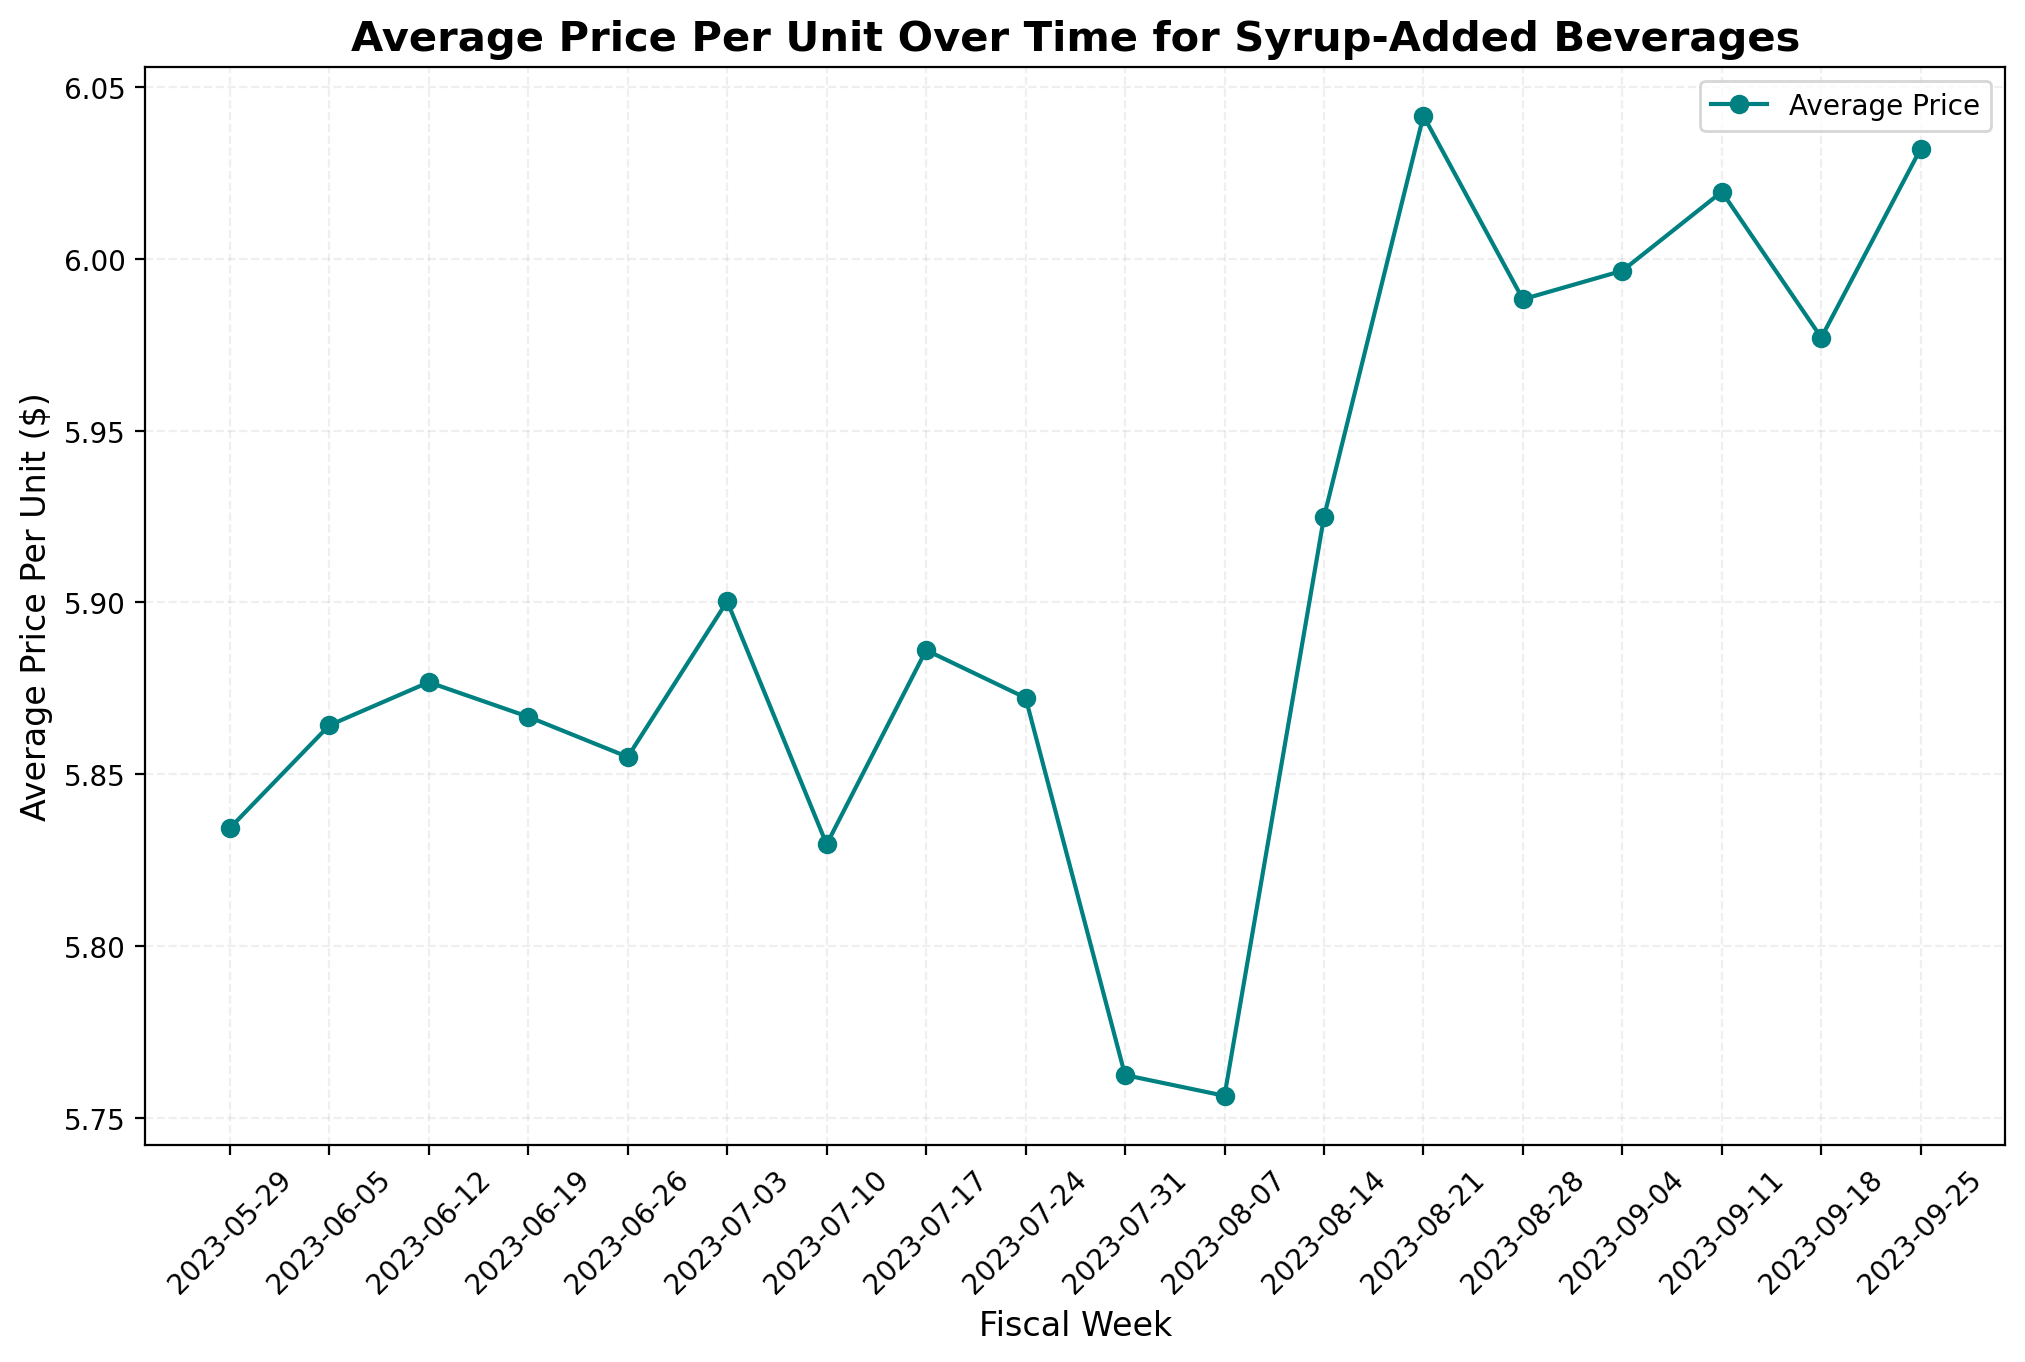

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

syrup_data = pd.read_sql_query(syrup_query, conn)

# Plot the data
plt.figure(figsize=(12, 7), dpi = 200)  # Larger figure size for better visibility
plt.plot(syrup_data['FiscalWeekBeginDate'], syrup_data['AVG(AveragePricePerUnit)'], marker='o', linestyle='-', color='teal', label='Average Price')

plt.title('Average Price Per Unit Over Time for Syrup-Added Beverages', fontsize=15, fontweight='bold')
plt.xlabel('Fiscal Week', fontsize=12)
plt.ylabel('Average Price Per Unit ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.2)  # Lighter grid lines for better readability
plt.legend(loc='upper right')

plt.show()

- **NOTE:** Average price around $5.9 looks realistic for a drink with syrup in 2023.

- **NOTE:** Important to decide on including zero-priced items; possibly indicating data inaccuracies. Analysis showed minor differences when excluding zero-priced syrup beverages.

---

# Appendix
A challenge in the dataset is transactions featuring multiple instances of 'Syrup' and various parents, similar to the example below. Accurately handling such cases is key to ensuring precise data interpretation.

In [6]:
# TEST
test_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
)

SELECT *
FROM MergedTables
WHERE POSTransactionId = "20230706010379016753"

"""
pd.read_sql_query(test_query, conn)

,FiscalWeekBeginDate,POSTransactionId,ParentItemId,ItemId,ItemQuantity,NetSales,ProductDescription
0,2023-07-03,20230706010379016753,128643,128643,1.0,4.45,OtherProduct
1,2023-07-03,20230706010379016753,128643,128643,1.0,4.45,OtherProduct
2,2023-07-03,20230706010379016753,128643,128643,1.0,4.45,OtherProduct
3,2023-07-03,20230706010379016753,128643,128643,1.0,4.45,OtherProduct
4,2023-07-03,20230706010379016753,128643,128643,1.0,4.45,OtherProduct
5,2023-07-03,20230706010379016753,128643,128643,1.0,4.45,OtherProduct
6,2023-07-03,20230706010379016753,128643,154162,3.0,0.00,Syrup
7,2023-07-03,20230706010379016753,128643,154162,3.0,0.00,Syrup
8,2023-07-03,20230706010379016753,128643,154162,3.0,0.00,Syrup
9,2023-07-03,20230706010379016753,128643,154162,3.0,0.00,Syrup


When syrup transactions involve multiple parents, inner joins can result in duplicate columns. To address this, I start by aggregating sales and quantity for identical rows, under the assumption that these repetitions are not due to data inaccuracies. This method transforms potentially duplicated transactions into consolidated entries, as illustrated in the example below.

In [7]:
# TEST
test_query = """
WITH MergedTables AS (
    SELECT ls.FiscalWeekBeginDate, ls. POSTransactionId, ls.ParentItemId, ls.ItemId , pr.ProductDescription, SUM(ls.ItemQuantity) AS ItemQuantity, SUM(ls.NetSales) AS NetSales
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
    GROUP BY 1, 2, 3, 4, 5
)

SELECT *
FROM MergedTables
WHERE POSTransactionId = "20230706010379016753"

"""
pd.read_sql_query(test_query, conn)

,FiscalWeekBeginDate,POSTransactionId,ParentItemId,ItemId,ProductDescription,ItemQuantity,NetSales
0,2023-07-03,20230706010379016753,128643,109845,OtherProduct,1.0,0.0
1,2023-07-03,20230706010379016753,128643,109893,OtherProduct,6.0,0.0
2,2023-07-03,20230706010379016753,128643,128643,OtherProduct,6.0,26.7
3,2023-07-03,20230706010379016753,128643,154162,Syrup,18.0,0.0
4,2023-07-03,20230706010379016753,128643,189840,OtherProduct,18.0,0.0
5,2023-07-03,20230706010379016753,128643,11001828,OtherProduct,6.0,3.6
